# Klasifikace hlasových záznamů z databáze VOICED

## 1. Úvod
Cílem této seminární práce je analýza a klasifikace hlasových záznamů z databáze VOICED (PhysioNet). Databáze obsahuje nahrávky od 208 subjektů, z nichž část je zdravá a část trpí patologickými změnami hlasu.

V této části práce se zaměříme na:
1.  Načtení dat a metadat pomocí knihovny `wfdb`.
2.  Zpracování signálu v časové a frekvenční oblasti (Fourierova transformace, Kepstrální analýza).
3.  Extrakci příznaků pro strojové učení.
4.  Klasifikaci na dvě skupiny (zdravý/patologický) a následně na specifické patologie.
5.  Vyhodnocení úspěšnosti klasifikace.

**Poznámka ke zpracování:** Pro manipulaci s daty jsou využity nástroje WFDB pouze pro načtení (`io`). Veškeré zpracování signálu je realizováno pomocí obecných matematických a signálových knihoven (`numpy`, `scipy`, `librosa`), aby byly dodrženy podmínky zadání.

In [ ]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft
import librosa
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Nastavení vizuálního stylu grafů
plt.style.use('seaborn-v0_8-whitegrid')

# Ověření verzí (volitelné)
print("Knihovny importovány.")

Knihovny importovány.


## 2. Načítání dat a parsování diagnóz
Data načítáme ze zdrojových souborů `.dat` a `.hea`. Klíčovým krokem je extrakce textové diagnózy z komentářů v hlavičce, která může být zapsána v různých formátech (např. `<diagnoses>: ...`).

In [ ]:
def load_voiced_data(data_path):
    """
    Načte záznamy z databáze VOICED.
    Robustně parsuje diagnózy z komentářů (řeší různé formáty zápisu).
    """
    records = []
    if not os.path.exists(data_path):
        print(f"CHYBA: Cesta '{data_path}' neexistuje. Zkontrolujte cestu.")
        return pd.DataFrame()

    for file in os.listdir(data_path):
        if file.endswith(".hea"):
            record_name = file.replace(".hea", "")
            full_path = os.path.join(data_path, record_name)
            
            try:
                # Použití WFDB pouze pro I/O operace
                record = wfdb.rdrecord(full_path)
                signal = record.p_signal.flatten()
                fs = record.fs
                comments = record.comments
                
                diagnosis = "Unknown"
                is_healthy = False
                
                # Sloučení komentářů do jednoho řetězce pro snazší hledání
                full_comment_str = " ".join(comments).lower()
                
                # Logika parsování diagnózy
                if "healthy" in full_comment_str:
                    diagnosis = "Healthy"
                    is_healthy = True
                else:
                    is_healthy = False
                    # Hledání klíčových slov pro diagnózu
                    if "diagnoses>:" in full_comment_str:
                        parts = full_comment_str.split("diagnoses>:")
                        if len(parts) > 1:
                            diagnosis = parts[1].strip().split("<")[0].strip()
                    elif "diagnosis:" in full_comment_str:
                        parts = full_comment_str.split("diagnosis:")
                        if len(parts) > 1:
                            diagnosis = parts[1].strip().split("<")[0].strip()
                    else:
                        diagnosis = "Pathological (Unspecified)"

                records.append({
                    "record_name": record_name,
                    "signal": signal,
                    "fs": fs,
                    "diagnosis": diagnosis,
                    "label_binary": "Healthy" if is_healthy else "Pathological"
                })
                
            except Exception as e:
                print(f"Chyba při čtení {record_name}: {e}")
                
    return pd.DataFrame(records)

data_path = './voice' 

df = load_voiced_data(data_path)

if not df.empty:
    print(f"Načteno {len(df)} záznamů.")
    print("\nRozložení tříd (Kontrola):")
    print(df['label_binary'].value_counts())
    print("\nUkázka dat:")
    display(df.head())

Načteno 208 záznamů.

Rozložení tříd (Kontrola):
label_binary
Pathological    151
Healthy          57
Name: count, dtype: int64

Ukázka dat:


,record_name,signal,fs,diagnosis,label_binary
0,voice001,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8000,hyperkinetic dysphonia,Pathological
1,voice002,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8000,Healthy,Healthy
2,voice003,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8000,hyperkinetic dysphonia,Pathological
3,voice004,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8000,hypokinetic dysphonia,Pathological
4,voice005,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8000,hypokinetic dysphonia,Pathological


## 3. Vizualizace signálů
Pro demonstraci rozdílů mezi zdravým a patologickým hlasem zobrazíme:
1.  **Časovou oblast (Oscilogram):** Průběh amplitudy signálu.
2.  **Frekvenční oblast (FFT):** Spektrální složení signálu. Patologické hlasy často vykazují více šumu a méně zřetelnou harmonickou strukturu.

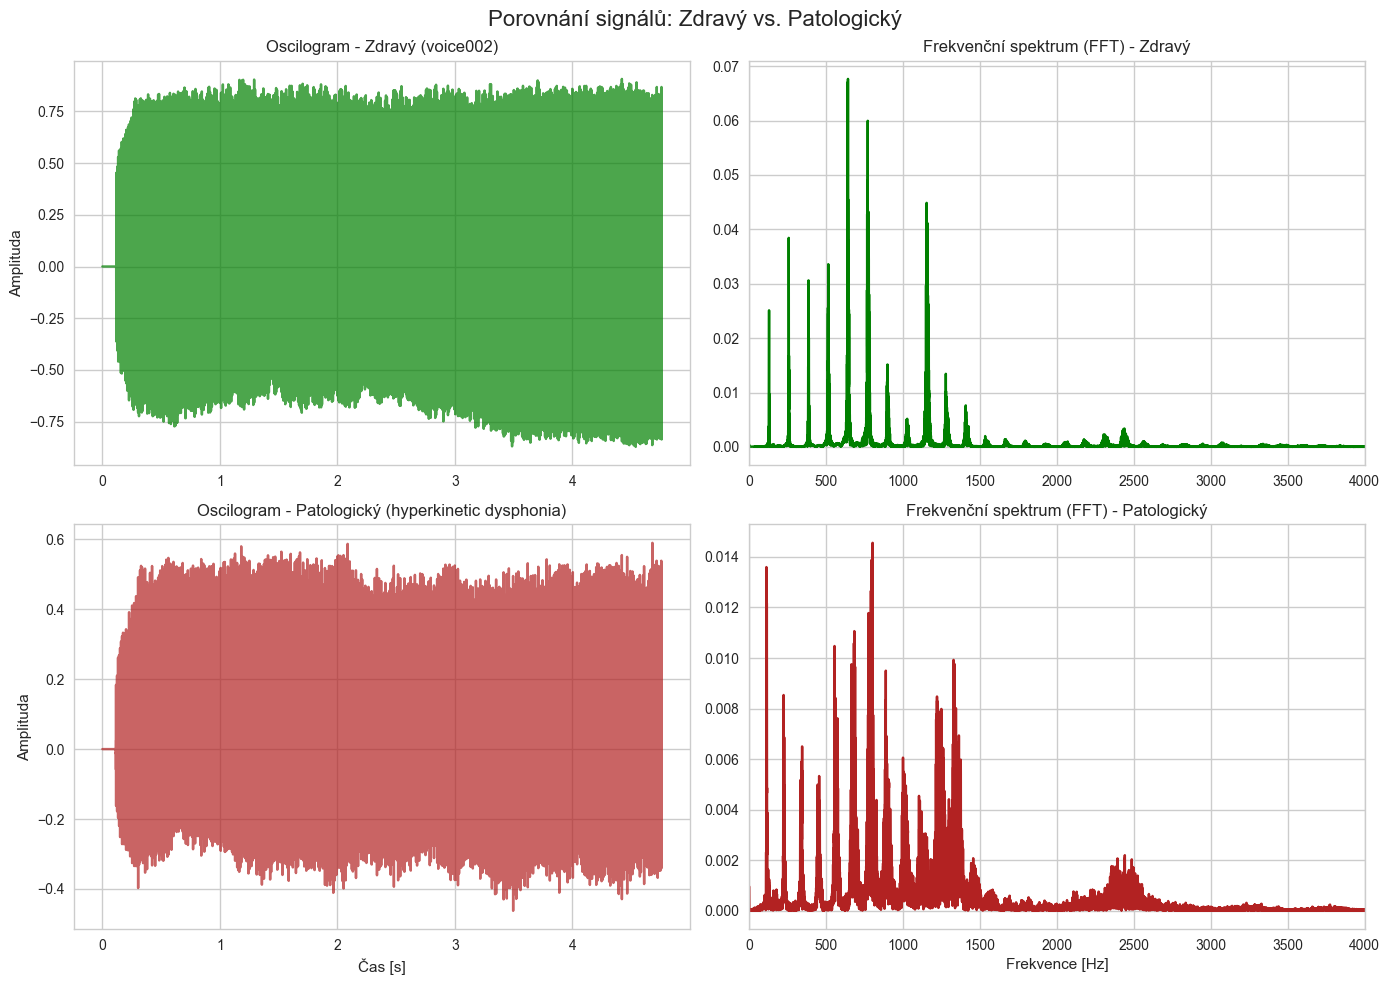

In [33]:
def plot_signal_analysis(df):
    # Výběr reprezentativních vzorků
    healthy = df[df['label_binary'] == 'Healthy'].iloc[0]
    # Zkusíme najít konkrétní diagnózu pro zajímavost, např. dysfonii, nebo vezmeme první patologický
    pathology = df[df['label_binary'] == 'Pathological'].iloc[0]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Porovnání signálů: Zdravý vs. Patologický', fontsize=16)
    
    # --- Časová oblast ---
    # Zdravý
    time_h = np.arange(len(healthy['signal'])) / healthy['fs']
    axes[0, 0].plot(time_h, healthy['signal'], color='green', alpha=0.7)
    axes[0, 0].set_title(f"Oscilogram - Zdravý ({healthy['record_name']})")
    axes[0, 0].set_ylabel("Amplituda")
    
    # Patologický
    time_p = np.arange(len(pathology['signal'])) / pathology['fs']
    axes[1, 0].plot(time_p, pathology['signal'], color='firebrick', alpha=0.7)
    axes[1, 0].set_title(f"Oscilogram - Patologický ({pathology['diagnosis']})")
    axes[1, 0].set_ylabel("Amplituda")
    axes[1, 0].set_xlabel("Čas [s]")

    # --- Frekvenční oblast (FFT) ---
    def calc_fft_plot(sig, fs):
        n = len(sig)
        yf = scipy.fft.fft(sig)
        xf = scipy.fft.fftfreq(n, 1/fs)
        return xf[:n//2], 2.0/n * np.abs(yf[:n//2])

    # Zdravý
    xh, yh = calc_fft_plot(healthy['signal'], healthy['fs'])
    axes[0, 1].plot(xh, yh, color='green')
    axes[0, 1].set_title("Frekvenční spektrum (FFT) - Zdravý")
    axes[0, 1].set_xlim(0, 4000) # Zoom na relevantní pásmo řeči
    axes[0, 1].grid(True)

    # Patologický
    xp, yp = calc_fft_plot(pathology['signal'], pathology['fs'])
    axes[1, 1].plot(xp, yp, color='firebrick')
    axes[1, 1].set_title(f"Frekvenční spektrum (FFT) - Patologický")
    axes[1, 1].set_xlim(0, 4000)
    axes[1, 1].set_xlabel("Frekvence [Hz]")
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

if not df.empty:
    plot_signal_analysis(df)

## 4. Extrakce příznaků (Feature Extraction)
Pro klasifikaci signálů je nutné převést zvuková data na číselné vektory příznaků. Využíváme techniky požadované v zadání:

* **ZCR (Zero Crossing Rate):** Míra průchodů nulou (koreluje s "šumovostí" signálu).
* **RMS (Root Mean Square):** Energie signálu.
* **Spektrální centroid:** "Těžiště" spektra (Fourierova analýza).
* **MFCC (Mel-Frequency Cepstral Coefficients):** Kepstrální analýza, která napodobuje lidské vnímání zvuku. Používáme průměrné hodnoty 13 koeficientů.

In [34]:
def extract_features(signal, fs):
    """
    Manuální extrakce příznaků pomocí numpy, scipy a librosa.
    """
    # Přetypování pro jistotu
    signal = signal.astype(float)
    
    # 1. Časová oblast
    rms = np.sqrt(np.mean(signal**2))
    zcr = ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)
    
    # 2. Frekvenční oblast (Fourier)
    spectrum = np.abs(scipy.fft.fft(signal))
    freqs = scipy.fft.fftfreq(len(signal), 1/fs)
    # Vážený průměr (centroid) na kladné části spektra
    pos_mask = freqs > 0
    if np.sum(spectrum[pos_mask]) == 0:
        centroid = 0
    else:
        centroid = np.sum(freqs[pos_mask] * spectrum[pos_mask]) / np.sum(spectrum[pos_mask])
    
    # 3. Kepstrální oblast (MFCC)
    mfccs = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    # Uložení do slovníku
    features = {
        'rms': rms,
        'zcr': zcr,
        'spectral_centroid': centroid
    }
    for i, val in enumerate(mfccs_mean):
        features[f'mfcc_{i+1}'] = val
        
    return features

# Hromadné zpracování
if not df.empty:
    print("Probíhá extrakce příznaků pro celý dataset...")
    feature_list = []
    
    for _, row in df.iterrows():
        feats = extract_features(row['signal'], row['fs'])
        feature_list.append(feats)
        
    features_df = pd.DataFrame(feature_list)
    # Spojení původních metadat s vypočtenými příznaky
    full_df = pd.concat([df[['diagnosis', 'label_binary']], features_df], axis=1)
    
    print("Extrakce dokončena.")
    display(full_df.head())

Probíhá extrakce příznaků pro celý dataset...
Extrakce dokončena.


,diagnosis,label_binary,rms,zcr,spectral_centroid,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,hyperkinetic dysphonia,Pathological,0.130236,0.229307,1158.195462,-89.878323,53.312515,-66.393846,-16.300682,-6.631975,17.999434,-27.778969,15.623700,6.169481,-34.712455,-3.559567,-6.395851,-8.561320
1,Healthy,Healthy,0.291000,0.218776,1058.374423,-115.652658,36.073274,-52.771162,-33.146484,-15.068009,3.447450,-22.321822,10.138316,13.726444,-27.952345,-21.330649,-14.298918,-6.626558
2,hyperkinetic dysphonia,Pathological,0.259768,0.209086,1505.803696,-57.845436,-3.434850,-42.967608,-35.288694,3.767250,5.081971,-20.880665,13.056897,-4.589232,-28.704122,-10.099688,-0.145197,-10.543688
3,hypokinetic dysphonia,Pathological,0.051169,0.157169,1370.842079,-206.126466,13.042708,-27.005930,32.183496,19.796031,-24.004164,11.081125,4.832909,-22.760615,-3.648753,-25.758860,-8.976304,-23.258990
4,hypokinetic dysphonia,Pathological,0.185829,0.238314,1327.631938,-104.151934,8.180843,-49.468008,-17.298141,28.267973,4.029834,-3.836589,-4.155939,-23.870635,1.722772,-17.541468,-1.895349,-22.703729


## 5. Klasifikace a Vyhodnocení
Model strojového učení: **Random Forest Classifier**.

### 5.1 Binární klasifikace (Zdravý vs. Patologický)
Rozdělení dat 80% trénink / 20% test.

In [35]:
if 'full_df' in locals():
    # Příprava dat
    X = full_df.drop(columns=['diagnosis', 'label_binary'])
    y = full_df['label_binary']
    
    # Rozdělení na trénovací a testovací sadu (stratifikované podle tříd)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Normalizace
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Trénink modelu
    clf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_bin.fit(X_train_scaled, y_train)
    
    # Predikce
    y_pred_bin = clf_bin.predict(X_test_scaled)
    
    # Výpis výsledků
    acc_bin = accuracy_score(y_test, y_pred_bin)
    print(f"--- Výsledky BINÁRNÍ klasifikace ---")
    print(f"Přesnost (Accuracy): {acc_bin:.2%}\n")
    print(classification_report(y_test, y_pred_bin))

--- Výsledky BINÁRNÍ klasifikace ---
Přesnost (Accuracy): 64.29%

              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        12
Pathological       0.69      0.90      0.78        30

    accuracy                           0.64        42
   macro avg       0.35      0.45      0.39        42
weighted avg       0.49      0.64      0.56        42



### 5.2 Klasifikace specifických patologií (Multiclass)
V této části pracujeme **pouze s patologickými záznamy**. Cílem je určit konkrétní diagnózu.
*Poznámka: Diagnózy s velmi nízkým počtem výskytů (< 4) jsou z tréninku vyřazeny, aby bylo možné validovat model.*

In [36]:
if 'full_df' in locals():
    # 1. Filtrace jen patologických
    path_df = full_df[full_df['label_binary'] == 'Pathological'].copy()
    
    # 2. Filtrace diagnóz s dostatečným počtem vzorků
    counts = path_df['diagnosis'].value_counts()
    valid_diags = counts[counts >= 4].index
    path_df_filtered = path_df[path_df['diagnosis'].isin(valid_diags)]
    
    print(f"Počet vzorků pro multiclass: {len(path_df_filtered)}")
    print(f"Zahrnuté diagnózy: {list(valid_diags)}")
    
    # Příprava dat
    X_multi = path_df_filtered.drop(columns=['diagnosis', 'label_binary'])
    y_multi = path_df_filtered['diagnosis']
    
    # Split
    X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
        X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
    )
    
    # Normalizace
    scaler_m = StandardScaler()
    X_train_m_s = scaler_m.fit_transform(X_train_m)
    X_test_m_s = scaler_m.transform(X_test_m)
    
    # Trénink
    clf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_multi.fit(X_train_m_s, y_train_m)
    
    # Predikce
    y_pred_multi = clf_multi.predict(X_test_m_s)
    
    acc_multi = accuracy_score(y_test_m, y_pred_multi)
    print(f"\n--- Výsledky MULTICLASS klasifikace ---")
    print(f"Přesnost: {acc_multi:.2%}")

Počet vzorků pro multiclass: 150
Zahrnuté diagnózy: ['hyperkinetic dysphonia', 'hypokinetic dysphonia', 'reflux laryngitis']

--- Výsledky MULTICLASS klasifikace ---
Přesnost: 40.00%


## 6. Grafické výstupy a Závěr
Zobrazujeme:
1.  **Matici záměn (Confusion Matrix):** Detailní pohled na chyby klasifikátoru konkrétních nemocí.
2.  **Scatterplot:** Vizualizace dat v prostoru dvou nejvýznamnějších příznaků, ukazující separaci tříd.
3.  **Souhrnnou tabulku úspěšnosti.**

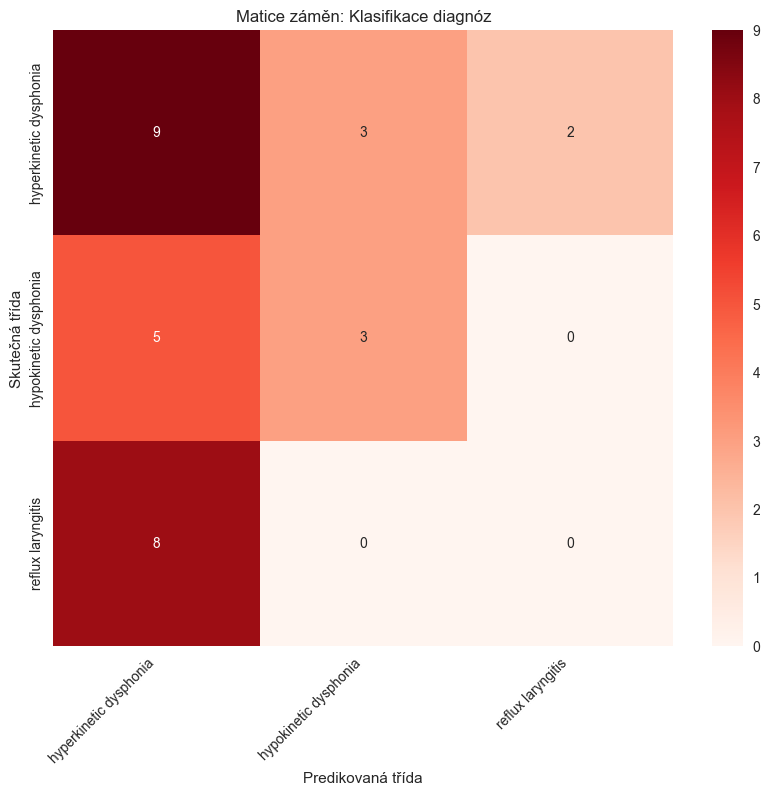

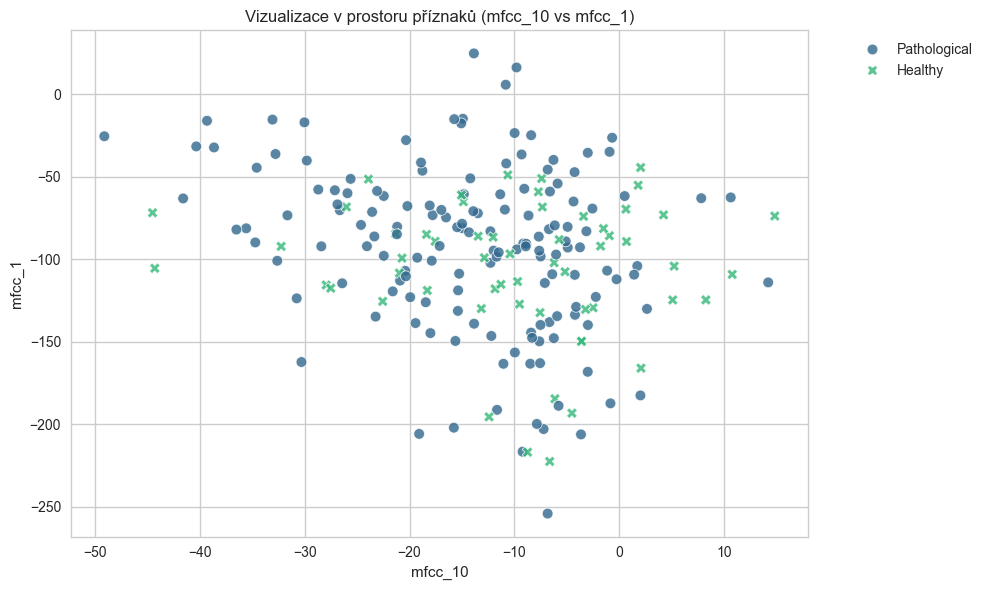


=== ZÁVĚREČNÉ VYHODNOCENÍ ===


,Typ úlohy,Dosažená přesnost (Accuracy)
0,Binární (Zdravý / Nemocný),64.29%
1,Multiclass (Konkrétní diagnóza),40.00%


In [37]:
# 1. Matice záměn (Multiclass)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_m, y_pred_multi)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=clf_multi.classes_, yticklabels=clf_multi.classes_)
plt.title('Matice záměn: Klasifikace diagnóz')
plt.ylabel('Skutečná třída')
plt.xlabel('Predikovaná třída')
plt.xticks(rotation=45, ha='right')
plt.show()

# 2. Scatterplot (Binární) - Hledání top features
importances = clf_bin.feature_importances_
indices = np.argsort(importances)[::-1]
# Vezmeme jména dvou nejdůležitějších sloupců
top_f1 = X.columns[indices[0]]
top_f2 = X.columns[indices[1]]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=full_df, x=top_f1, y=top_f2, hue='label_binary', style='label_binary', palette='viridis', s=60, alpha=0.8)
plt.title(f'Vizualizace v prostoru příznaků ({top_f1} vs {top_f2})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Souhrnná tabulka
results_table = pd.DataFrame({
    'Typ úlohy': ['Binární (Zdravý / Nemocný)', 'Multiclass (Konkrétní diagnóza)'],
    'Dosažená přesnost (Accuracy)': [f"{acc_bin:.2%}", f"{acc_multi:.2%}"]
})

print("\n=== ZÁVĚREČNÉ VYHODNOCENÍ ===")
display(results_table)